In [110]:
import os
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import timm

In [111]:
# List all models  
available_models = timm.list_models("*dino*")
print(available_models)

['vit_base_patch14_dinov2', 'vit_base_patch14_reg4_dinov2', 'vit_giant_patch14_dinov2', 'vit_giant_patch14_reg4_dinov2', 'vit_large_patch14_dinov2', 'vit_large_patch14_reg4_dinov2', 'vit_small_patch14_dinov2', 'vit_small_patch14_reg4_dinov2']


In [112]:
# Step 1 : Load the model
model_name = "vit_large_patch14_dinov2"
model = timm.create_model(model_name, pretrained=True, features_only=True)
model.eval()

FeatureGetterNet(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approx

In [113]:
# Step 3 : Preprocess the images
transform = T.Compose([
    T.Resize((518, 518)),  
    T.ToTensor(),  
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

image_path = "images/Train.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  
input_tensor.shape  


torch.Size([1, 3, 518, 518])

In [114]:
# Step 4 : Forward pass
with torch.no_grad():
    features = model(input_tensor)  # Features

In [115]:
# Step 5 : Display the feature map
feature_map = features[-1][0]  # Select last layer's feature map
print("Shape of selected feature map:", feature_map.shape)  # (C, H, W)


Shape of selected feature map: torch.Size([1024, 37, 37])


In [116]:
# Normalize the feature map
# Normalisation 0-1
feature_map = feature_map[0].cpu().numpy()
feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())  # Normalisation 0-1

feature_map.shape

(37, 37)

In [117]:
# Step 6 : Superposition

# Resize the image to feature map's shape
image_resized = image.resize((feature_map.shape[1], feature_map.shape[0]))
image_np = np.array(image_resized) 

if len(image_np.shape) == 2:  
    image_np = np.stack([image_np] * 3, axis=-1) 

image_np = image_np / 518.0

# Superposition with transparency
superposed = 0.9 * image_np + 0.1 * plt.cm.jet(feature_map)[..., :3]



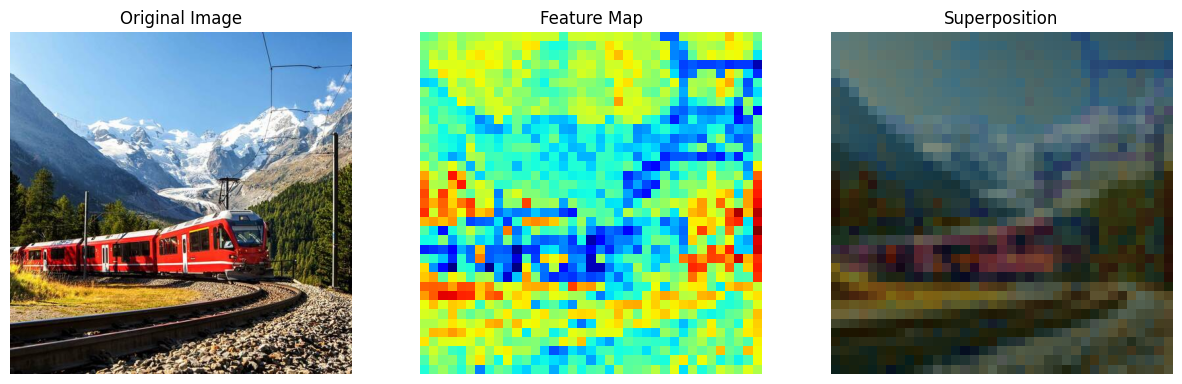

In [118]:
# Étape 7 : Visualisation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Feature map
axes[1].imshow(feature_map, cmap="jet")
axes[1].set_title("Feature Map")
axes[1].axis("off")

# Superposition
axes[2].imshow(superposed)
axes[2].set_title("Superposition")
axes[2].axis("off")

plt.show()